In [1]:
# Notebook init
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os, sys; sys.path.insert(0, os.path.join(os.getcwd(), '../..'))
print(sys.path)

import data_pipelines.util as data_util

# Disable fetching new data?  Assign no_update.
import data_pipelines
#data_pipelines.settings.no_update = True

['/home/waltw/dev/covid-19-staging/sandbox/COVID-19_WW/../..', '/home/waltw/dev/covid-19-staging/sandbox/COVID-19_WW', '/home/waltw/dev/covid-19-staging/sandbox/COVID-19_WW', '/home/waltw/miniconda3/lib/python37.zip', '/home/waltw/miniconda3/lib/python3.7', '/home/waltw/miniconda3/lib/python3.7/lib-dynload', '', '/home/waltw/miniconda3/lib/python3.7/site-packages', '/home/waltw/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/waltw/.ipython']


In [2]:
# Data pipeline fetching
import data_pipelines.county_descarteslabs_mobility as mobility
import data_pipelines.county_nytimes_covid_stats as covid
import data_pipelines.county_usda_census as census
import data_pipelines.state_covidtracking_com_covid_testing as testing

df_m = mobility.get()
df_c = covid.get()
df_p = census.get()['population']
df_t = testing.get()

In [3]:
df_m_j = df_m.loc[pd.notna(df_m['county']) & pd.notna(df_m['date'])]
df_c_j = df_c.loc[pd.notna(df_c['county']) & pd.notna(df_c['date'])]
df_p_j = df_p.loc[pd.notna(df_p['county'])]
df_t_j = df_t.loc[pd.notna(df_t['state'])]

# Roll population data into NYTimes
df_p_j['population'] = df_p_j['POP_ESTIMATE_latest']
df_p_j = df_p_j[['county', 'population']]
df_c_j = df_c_j.set_index(['county']).join(df_p_j.set_index('county')).reset_index()

# Roll testing data into NYTimes
t_data = df_t_j[['state', 'date', 'positive', 'negative', 'pending']]
t_data = t_data.rename({'positive': 'testing_positive', 'negative': 'testing_negative', 
                        'pending': 'testing_pending'}, 
                       axis=1)
t_data['testing_pending'].fillna(0, inplace=True)
t_data['testing_total'] = t_data['testing_positive'] + t_data['testing_negative'] + t_data['testing_pending']
df_c_j = df_c_j.merge(t_data, on=('state', 'date')).reset_index()

# Default join is left.  We want to maximize available case data, regardless of m50
df = df_m_j.set_index(['county', 'date']).join(df_c_j.set_index(['county', 'date']), 
        how='right', rsuffix='_c')
import dateutil.parser
df = df.reset_index()
df['date'] = df['date'].map(lambda x: dateutil.parser.parse(x))
df = df.set_index(['county', 'date'])

In [4]:
df

country_code  admin_level   admin1          admin2  samples  \
county date                                                                     
01001  2020-03-24           US          2.0  Alabama  Autauga County   1758.0   
       2020-03-25           US          2.0  Alabama  Autauga County   1752.0   
       2020-03-26           US          2.0  Alabama  Autauga County   1757.0   
       2020-03-27           US          2.0  Alabama  Autauga County   1725.0   
       2020-03-28           US          2.0  Alabama  Autauga County   1735.0   
...                        ...          ...      ...             ...      ...   
78999  2020-03-27          NaN          NaN      NaN             NaN      NaN   
       2020-03-28          NaN          NaN      NaN             NaN      NaN   
       2020-03-29          NaN          NaN      NaN             NaN      NaN   
       2020-03-30          NaN          NaN      NaN             NaN      NaN   
       2020-03-31          NaN          NaN      NaN             NaN      NaN   

                     m50  m50_index state  index state_c  cases  deaths  \
county date                                                               
01001  2020-03-24  7.030       48.0    AL      0      AL      1       0   
       2020-03-25  6.912       47.0    AL     26      AL      4       0   
       2020-03-26  6.731       46.0    AL     67      AL      6       0   
       2020-03-27  7.601       52.0    AL    115      AL      6       0   
       2020-03-28  4.540       31.0    AL    168      AL      6       0   
...                  ...        ...   ...    ...     ...    ...     ...   
78999  2020-03-27    NaN        NaN   NaN  23439      VI     19       0   
       2020-03-28    NaN        NaN   NaN  23440      VI     19       0   
       2020-03-29    NaN        NaN   NaN  23441      VI     23       0   
       2020-03-30    NaN        NaN   NaN  23442      VI     30       0   
       2020-03-31    NaN        NaN   NaN  23443      VI     30       0   

                   population  testing_positive  testing_negative  \
county date                                                         
01001  2020-03-24     55601.0             215.0            2106.0   
       2020-03-25     55601.0             283.0            2529.0   
       2020-03-26     55601.0             506.0            3593.0   
       2020-03-27     55601.0             587.0            4184.0   
       2020-03-28     55601.0             696.0            4184.0   
...                       ...               ...               ...   
78999  2020-03-27         NaN              19.0              55.0   
       2020-03-28         NaN              22.0             106.0   
       2020-03-29         NaN              23.0             123.0   
       2020-03-30         NaN              30.0             126.0   
       2020-03-31         NaN              30.0             126.0   

                   testing_pending  testing_total  
county date                                        
01001  2020-03-24              0.0         2321.0  
       2020-03-25              0.0         2812.0  
       2020-03-26              0.0         4099.0  
       2020-03-27              0.0         4771.0  
       2020-03-28              0.0         4880.0  
...                            ...            ...  
78999  2020-03-27              2.0           76.0  
       2020-03-28             55.0          183.0  
       2020-03-29             37.0          183.0  
       2020-03-30             24.0          180.0  
       2020-03-31             24.0          180.0  

[23467 rows x 17 columns]

In [5]:
df.loc[data_util.resolve_county('multnomah', 'or')]

,country_code,admin_level,admin1,admin2,samples,m50,m50_index,state,index,state_c,cases,deaths,population,testing_positive,testing_negative,testing_pending,testing_total
date,,,,,,,,,,,,,,,,,
2020-03-10,US,2.0,Oregon,Multnomah County,9210.0,4.924,98.0,OR,17150,OR,1,0,811880.0,15.0,213.0,67.0,295.0
2020-03-11,US,2.0,Oregon,Multnomah County,9247.0,4.780,95.0,OR,17132,OR,1,0,811880.0,19.0,286.0,62.0,367.0
2020-03-12,US,2.0,Oregon,Multnomah County,9154.0,5.006,99.0,OR,17088,OR,1,0,811880.0,19.0,286.0,62.0,367.0
2020-03-13,US,2.0,Oregon,Multnomah County,9005.0,4.490,89.0,OR,17099,OR,1,0,811880.0,30.0,337.0,157.0,524.0
2020-03-14,US,2.0,Oregon,Multnomah County,8512.0,1.506,29.0,OR,17110,OR,1,1,811880.0,30.0,337.0,157.0,524.0
2020-03-15,US,2.0,Oregon,Multnomah County,8477.0,1.287,25.0,OR,17121,OR,1,1,811880.0,36.0,420.0,225.0,681.0
2020-03-16,US,2.0,Oregon,Multnomah County,8446.0,2.861,56.0,OR,16783,OR,2,1,811880.0,39.0,579.0,182.0,800.0
2020-03-17,US,2.0,Oregon,Multnomah County,8911.0,2.015,40.0,OR,16797,OR,3,1,811880.0,47.0,689.0,184.0,920.0
2020-03-18,US,2.0,Oregon,Multnomah County,8490.0,1.890,37.0,OR,16811,OR,3,1,811880.0,75.0,1118.0,361.0,1554.0


In [6]:
df.loc[data_util.resolve_county('new york', 'ny')]

,country_code,admin_level,admin1,admin2,samples,m50,m50_index,state,index,state_c,cases,deaths,population,testing_positive,testing_negative,testing_pending,testing_total
date,,,,,,,,,,,,,,,,,
2020-03-04,US,2.0,New York,New York County,16326.0,2.023,102.0,NY,14659,NY,2,0,1628701.0,6.0,48.0,24.0,78.0
2020-03-05,US,2.0,New York,New York County,15078.0,2.046,104.0,NY,14627,NY,4,0,1628701.0,22.0,76.0,24.0,122.0
2020-03-06,US,2.0,New York,New York County,15300.0,1.966,100.0,NY,14630,NY,5,0,1628701.0,33.0,92.0,236.0,361.0
2020-03-07,US,2.0,New York,New York County,15464.0,1.016,51.0,NY,14634,NY,12,0,1628701.0,76.0,92.0,236.0,404.0
2020-03-08,US,2.0,New York,New York County,15803.0,0.606,30.0,NY,14639,NY,14,0,1628701.0,105.0,92.0,0.0,197.0
2020-03-09,US,2.0,New York,New York County,16172.0,1.953,99.0,NY,14646,NY,20,0,1628701.0,142.0,92.0,0.0,234.0
2020-03-10,US,2.0,New York,New York County,15862.0,1.713,87.0,NY,14653,NY,37,0,1628701.0,173.0,92.0,0.0,265.0
2020-03-11,US,2.0,New York,New York County,15676.0,1.855,94.0,NY,14620,NY,52,0,1628701.0,216.0,92.0,0.0,308.0
2020-03-12,US,2.0,New York,New York County,15536.0,1.614,82.0,NY,13821,NY,96,0,1628701.0,216.0,92.0,0.0,308.0


In [7]:
df.loc[data_util.resolve_county('palm beach', 'fl')][['m50_index', 'cases']].reset_index()

,date,m50_index,cases
0,2020-03-12,99.0,2
1,2020-03-13,99.0,5
2,2020-03-14,69.0,5
3,2020-03-15,48.0,5
4,2020-03-16,73.0,7
5,2020-03-17,66.0,11
6,2020-03-18,53.0,20
7,2020-03-19,55.0,28
8,2020-03-20,62.0,41
9,2020-03-21,26.0,56


Text(0.01, 0.99, "Above are plots re: mobility (proxy for policy) and number\nof reported cases, normalized by population.  Green lines of \nstate testing indicate case count is unreliable, as testing hasn't\nkept up.\n\nLeft are plots demonstrating volume of tests, and percent of all \ntests coming back positive.\n\nIt's pretty clear that testing hasn't caught up to rate of spread, \nlimiting the utility of projections based on disease counts. \n")

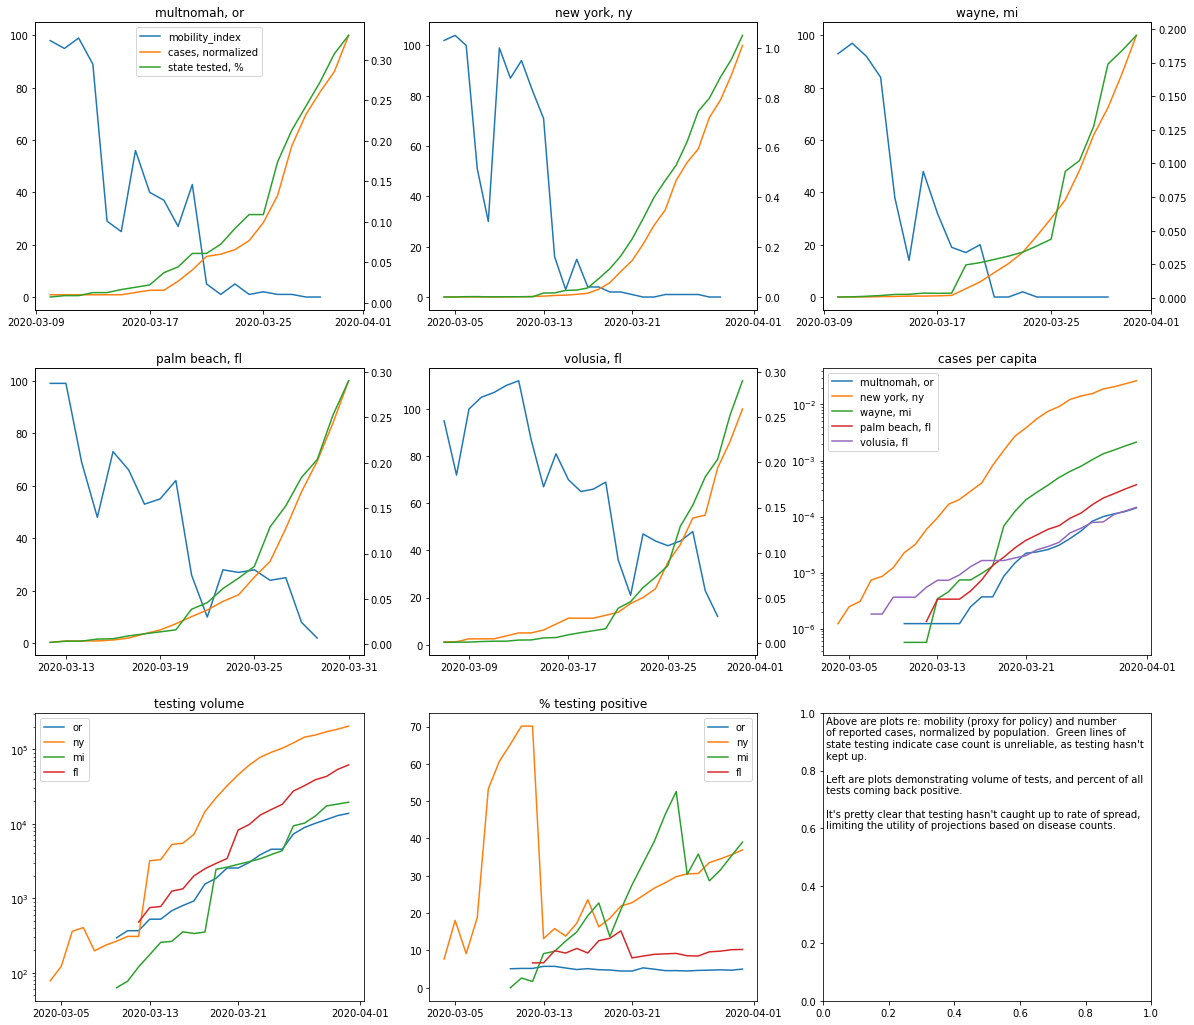

In [54]:
# Volusia, FL contains Daytona beach
sites = [['multnomah', 'or'], ['new york', 'ny'], ['wayne', 'mi'], ['palm beach', 'fl'], ['volusia', 'fl']]
cols = 3
rows = int(np.ceil((4 + len(sites)) / cols))
f, axs2d = plt.subplots(rows, cols, figsize=(20, 6 * rows), squeeze=False)
nticks = 4
def reduce_ticks(ax, axis_name, count):
    ticks = getattr(ax, f'get_{axis_name}ticks')()
    ticks = [ticks[i] for i in np.linspace(0, len(ticks) - 1, count, dtype=int)]
    getattr(ax, f'set_{axis_name}ticks')(ticks)
axs = []
for a in axs2d:
    axs.extend(a)
df_state_pop = df_p[['county', 'POP_ESTIMATE_latest']].set_index('county')
for s, ax in zip(sites, axs):
    ax.set_title(', '.join(s))
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    
    ax.plot(d['date'].values, d['m50_index'].values, label='mobility_index')
    ax.plot(d['date'].values, (100 * d['cases'] / d['cases'].max()).values, label='cases, normalized')
    
    # Testing is per-state, so normalize against state-wide population
    state_pop = df_state_pop.loc[data_util.resolve_county('all', s[1])]['POP_ESTIMATE_latest']
    tested_pop = d['testing_total']
    # Dummy for legend
    fake = ax.plot(d['date'].values[:1], d['cases'].values[:1], label='state tested, %')
    ax2 = ax.twinx()
    ax2.plot(d['date'].values, (100 * tested_pop / state_pop).values, label='state tested, % pop',
            color=fake[0].get_color())
    reduce_ticks(ax, 'x', nticks)
axs[0].legend()
    
# Combined
ax = axs[len(sites)]
ax.set_title('cases per capita')
ax.set_yscale('log')
for s in sites:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    cases_per = d['cases'] / d['population']
    ax.plot(d['date'].values, cases_per.values, label=', '.join(s))
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Testing volume (state-level)
ax = axs[len(sites)+1]
ax.set_title('testing volume')
ax.set_yscale('log')
sites_no_dup_states = [s for i, s in enumerate(sites) if s[1] not in [v[1] for v in sites[:i]]]
for s in sites_no_dup_states:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    ax.plot(d['date'].values, d['testing_total'].values, label=s[1])
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Testing rates
ax = axs[len(sites)+2]
ax.set_title('% testing positive')
for s in sites_no_dup_states:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    testing_total = d['testing_total']
    testing_pct = 100 * d['testing_positive'] / d['testing_total']
    ax.plot(d['date'].values, testing_pct.values, label=s[1])
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Notes
ax = axs[len(sites)+3]
ax.text(0.01, 0.99, 
        "Above are plots re: mobility (proxy for policy) and number\n\
of reported cases, normalized by population.  Green lines of \n\
state testing indicate case count is unreliable, as testing hasn't\n\
kept up.\n\
\n\
Left are plots demonstrating volume of tests, and percent of all \n\
tests coming back positive.\n\
\n\
It's pretty clear that testing hasn't caught up to rate of spread, \n\
limiting the utility of projections based on disease counts. \n\
", 
        transform=ax.transAxes, 
        horizontalalignment='left', verticalalignment='top')